In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from astropy.cosmology import Planck13

In [2]:
import os
from astropy.table import Table
dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction"
history_fname = "sfh_catalog_1.002310_smcut_9.50_value_added_histories.hdf5"
histories = Table.read(os.path.join(dirname, history_fname), path='data')
cosmic_age_array = np.load(os.path.join(dirname, 'times.npy'))

In [3]:
from read_sfh import get_scales
dirname="/Users/aphearin/Dropbox/UniverseMachine/data/histories"
basename="small_sfh_catalog_1.002310.txt"
tree_fname = os.path.join(dirname, basename)
scale_factor_array = get_scales(tree_fname)
redshift_array = (1./scale_factor_array) - 1
redshift_array[-1] = 0.

## Create z=0 sample masks

In [4]:
histories['logssfr'] = np.log10(histories['sfr']/histories['sm'])

In [5]:
logsm_bins = np.arange(9.5, 11.75, 0.25)
sm_mask_array = np.zeros((len(logsm_bins)-1, len(histories)), dtype=bool)
quenched_sm_mask_array = np.zeros_like(sm_mask_array, dtype=bool)
active_sm_mask_array = np.zeros_like(sm_mask_array, dtype=bool)
centrals_sm_mask_array = np.zeros_like(sm_mask_array, dtype=bool)
quenched_centrals_sm_mask_array = np.zeros_like(sm_mask_array)
active_centrals_sm_mask_array = np.zeros_like(sm_mask_array)
satellites_sm_mask_array = np.zeros_like(sm_mask_array)
quenched_satellites_sm_mask_array = np.zeros_like(sm_mask_array)
active_satellites_sm_mask_array = np.zeros_like(sm_mask_array)

for ibin, logsm_low, logsm_high in zip(range(sm_mask_array.shape[0]), logsm_bins[:-1], logsm_bins[1:]):
    sm_mask_array[ibin, :] = (histories['sm'] >= 10**logsm_low) & (histories['sm'] < 10**logsm_high)
    quenched_sm_mask_array[ibin, :] = sm_mask_array[ibin, :]*(histories['logssfr'] <= -11)
    active_sm_mask_array[ibin, :] = sm_mask_array[ibin, :]*(histories['logssfr'] > -11)
    
    centrals_sm_mask_array[ibin, :] = sm_mask_array[ibin, :]*(histories['upid'] == -1)
    quenched_centrals_sm_mask_array[ibin, :] = centrals_sm_mask_array[ibin, :]*(histories['logssfr'] <= -11)
    active_centrals_sm_mask_array[ibin, :] = centrals_sm_mask_array[ibin, :]*(histories['logssfr'] > -11)
    
    satellites_sm_mask_array[ibin, :] = sm_mask_array[ibin, :]*(histories['upid'] != -1)
    quenched_satellites_sm_mask_array[ibin, :] = satellites_sm_mask_array[ibin, :]*(histories['logssfr'] <= -11)
    active_satellites_sm_mask_array[ibin, :] = satellites_sm_mask_array[ibin, :]*(histories['logssfr'] > -11)

### Calculate average ssfr histories for all galaxies

In [6]:
from history_functions import ssfr_histories

In [7]:
mean_ssfh_sm = np.zeros((sm_mask_array.shape[0], len(cosmic_age_array)))

for ibin in range(mean_ssfh_sm.shape[0]):
    mean_ssfh_sm[ibin, :] = np.mean(ssfr_histories(histories['sfh'][sm_mask_array[ibin,:]],
                                                   histories['smh'][sm_mask_array[ibin,:]]), axis=0)
                                                   

### Make the plot

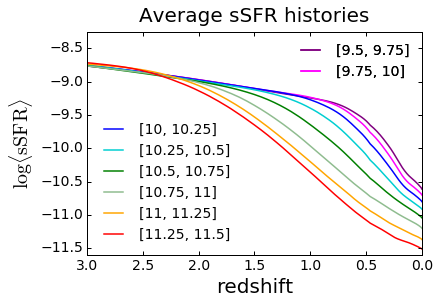

In [13]:
from scipy.signal import savgol_filter

fig1 = plt.figure()
ax = fig1.add_subplot(111)
# ax2 = ax.twiny()

xlabel = ax.set_xlabel('redshift', fontsize=20)
ylabel = ax.set_ylabel(r'$\log \langle {\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title('Average sSFR histories', fontsize=20, y=1.02) # y param fixes an overhanging title

ifirst=0

lw = 1.5
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[0, ifirst:], 21, 3), 
         color='purple', linewidth=lw)

ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[1, ifirst:], 21, 3), 
         color='magenta', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[2, ifirst:], 21, 3), 
         color='blue', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[3, ifirst:], 21, 3), 
         color='darkturquoise', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[4, ifirst:], 21, 3), 
         color='green', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[5, ifirst:], 21, 3), 
         color='darkseagreen', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[6, ifirst:], 21, 3), 
         color='orange', linewidth=lw)
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[7, ifirst:], 21, 3), 
         color='red', linewidth=lw)

# new_tick_locations = np.array([1, .5, 0.])
# def tick_function(z):
#     return ["%.3f" % t for t in (Planck13.age(0).value - Planck13.age(z).value)]

# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(new_tick_locations)
# ax2.set_xticklabels(tick_function(new_tick_locations))
# ax2.set_xlabel(r"Lookback time  [Gyr]")

plt.xlim(xmin = 3, xmax=0)
plt.ylim(ymin = -11.6, ymax = -8.25)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

purple_line = mlines.Line2D([], [], ls = '-', c = 'purple', linewidth=lw, label='[9.5, 9.75]')
magenta_line = mlines.Line2D([], [], ls = '-', c = 'magenta', linewidth=lw, label='[9.75, 10]')
blue_line = mlines.Line2D([], [], ls = '-', c = 'blue', linewidth=lw, label='[10, 10.25]')
darkturquoise_line = mlines.Line2D([], [], ls = '-', c = 'darkturquoise', linewidth=lw, label='[10.25, 10.5]')
green_line = mlines.Line2D([], [], ls = '-', c = 'green', linewidth=lw, label='[10.5, 10.75]')
darkseagreen_line = mlines.Line2D([], [], ls = '-', c = 'darkseagreen', linewidth=lw, label='[10.75, 11]')
orange_line = mlines.Line2D([], [], ls = '-', c = 'orange', linewidth=lw, label='[11, 11.25]')
red_line = mlines.Line2D([], [], ls = '-', c = 'red', linewidth=lw, label='[11.25, 11.5]')

first_legend = plt.legend(handles=[blue_line, darkturquoise_line, green_line, 
                                   darkseagreen_line, orange_line, red_line], 
                                frameon=False, loc='lower left', fontsize=14)
ax.add_artist(first_legend)

second_legend = plt.legend(handles=[purple_line, magenta_line], 
                                frameon=False, loc='upper right', fontsize=14)
ax.add_artist(second_legend)

fig1.savefig('FIGS/average_ssfr_history_sm_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## sSFR histories: centrals vs. satellites

### Calculate average ssfr histories for cens and sats

In [14]:
mean_ssfh_sm_centrals = np.zeros((centrals_sm_mask_array.shape[0], len(cosmic_age_array)))
for ibin in range(mean_ssfh_sm.shape[0]):
    mean_ssfh_sm_centrals[ibin, :] = np.mean(ssfr_histories(histories['sfh'][centrals_sm_mask_array[ibin,:]],
                                                   histories['smh'][centrals_sm_mask_array[ibin,:]]), axis=0)

mean_ssfh_sm_satellites = np.zeros((satellites_sm_mask_array.shape[0], len(cosmic_age_array)))
for ibin in range(mean_ssfh_sm.shape[0]):
    mean_ssfh_sm_satellites[ibin, :] = np.mean(ssfr_histories(histories['sfh'][satellites_sm_mask_array[ibin,:]],
                                                   histories['smh'][satellites_sm_mask_array[ibin,:]]), axis=0)

### Make the plot

In [ ]:
fig1 = plt.figure()
ax = fig.add_subplot(111)
# ax2 = ax.twiny()

xlabel = ax.set_xlabel('redshift', fontsize=20)
ylabel = ax.set_ylabel(r'$\log \langle {\rm sSFR}\rangle$', fontsize=20)
title = ax.set_title('Average sSFR histories', fontsize=20, y=1.02) # y param fixes an overhanging title

ifirst=0

lw = 1.5
ax.plot(redshift_array, savgol_filter(mean_ssfh_sm[0, ifirst:], 21, 3), 
         color='purple', linewidth=lw, label='[9.5, 9.75]')
